# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.348167
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *With very low weights will have scores close to 0. So, when we exponentiate the scores, will have values close to 1, and after normalizing, we have a value close to 1/C for each class (where C is the number of classes). Since we have 10 classes, the expected output for the loss is -log(1/10) = -log(0.1).*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.516019 analytic: 1.516019, relative error: 2.448204e-09
numerical: 1.649661 analytic: 1.649661, relative error: 1.913609e-08
numerical: -1.093675 analytic: -1.093675, relative error: 6.864515e-08
numerical: -1.515525 analytic: -1.515525, relative error: 5.871829e-09
numerical: 1.176517 analytic: 1.176516, relative error: 8.503758e-08
numerical: -0.505934 analytic: -0.505934, relative error: 2.969784e-08
numerical: 2.983908 analytic: 2.983908, relative error: 6.899563e-09
numerical: 1.939334 analytic: 1.939334, relative error: 1.567675e-09
numerical: 0.927218 analytic: 0.927218, relative error: 4.790515e-08
numerical: -2.250924 analytic: -2.250924, relative error: 3.581056e-10
numerical: -0.039233 analytic: -0.039233, relative error: 5.766933e-07
numerical: -0.789337 analytic: -0.789337, relative error: 3.740620e-08
numerical: -4.763598 analytic: -4.763598, relative error: 6.296814e-09
numerical: 2.117079 analytic: 2.117079, relative error: 3.187273e-08
numerical: -0.125537

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.348167e+00 computed in 0.120093s
vectorized loss: 2.348167e+00 computed in 0.003592s
Loss difference: 0.000000
Gradient difference: 0.000000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax

learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
def cross_validation(max_count, lr_range, reg_range, num_iters=100):
    
    # results is dictionary mapping tuples of the form
    # (learning_rate, regularization_strength) to tuples of the form
    # (training_accuracy, validation_accuracy). The accuracy is simply the fraction
    # of data points that are correctly classified.
    results = {}
    best_val = -1   # The highest validation accuracy that we have seen so far.
    best_softmax = None # The LinearSVM object that achieved the highest validation rate.
    
    """
    Cross validate the svm classifier for learning rate and regularization hyperparameters.
    
    Inputs:
    - max_count: (integer) with the number of combinations of the hyperparameters
    - lr_range: two-dimensional array with the learning rate interval trough whico we're
      going to cross validate
    - reg_range: two-dimensional array with the regularization strength interval
    - num_iters: (integer) representing the number of epochs in training 
    """
    
    for count in range(max_count):
        lr  = np.random.uniform(lr_range[0], lr_range[1])
        reg = np.random.uniform(reg_range[0], reg_range[1])

        classifier = Softmax()
        classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=num_iters, verbose=False)

        # predict the training set
        y_train_pred   = classifier.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)

        # predict the validation set
        y_val_pred   = classifier.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        # save the result at the dictionary
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # save the best validation accuracy and classifier
        if (best_val < val_accuracy):
            best_val = val_accuracy
            best_softmax = classifier
            
    return results, best_val, best_softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# results, best_val, best_softmax = cross_validation(100, [1e-10,1e-5], [1e+04, 5e+04], 10)
# results, best_val, best_softmax = cross_validation(100, [5e-6, 6e-6], [2e+4, 3e+4], 150)
# results, best_val, best_softmax = cross_validation(100, [5e-6, 5.2e-6], [2.1e+4, 2.7e+4], 500)
results, best_val, best_softmax = cross_validation(1, [5.1e-06, 5.1e-06], [2.6e+04, 2.6e+04], 5000)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.100000e-06 reg 2.600000e+04 train accuracy: 0.198857 val accuracy: 0.205000
best validation accuracy achieved during cross-validation: 0.205000


In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.181000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: With the Softmax classfier we're always trying to get to 100% (which is achieved only on limit case). With the SVM, once the correct class has the highest score, the classifier won't try to get better.

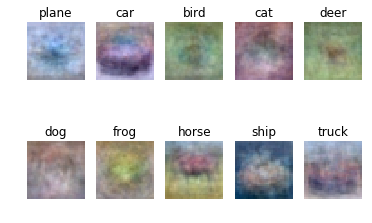

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])